In [1]:
import copy
import torch, torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor

In [2]:
#prepping the tranfromation of images
transformations = torchvision.transforms.Compose([
    ToTensor()
])

#importing the datasets
train_dataset = torchvision.datasets.MNIST('mnist_data', train = True, download = True, transform = transformations)
val_dataset = torchvision.datasets.MNIST('mnist_data', train = False, download = True, transform = transformations)

#we need to use a dataloader to load in the datasets - associates labels with dataset images
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 64)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

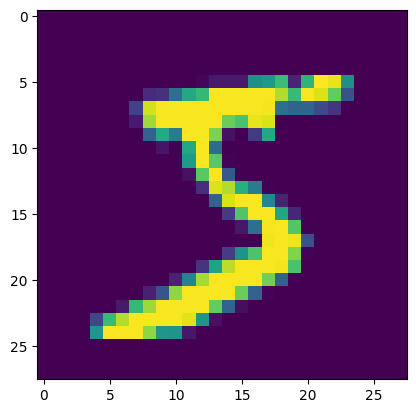

In [3]:
#visualizing any image in the set
#vary the numbers in teh tensor to visuaize a different value in the dataset.
img_tensor = train_dataset[0][0][0]
print(img_tensor)

plt.imshow(img_tensor)

In [4]:
def create_CNN():
    model = nn.Sequential(
        #We use ReLU function a lot in each layer because of the importance of edges in the images.
        #A Sigmoid function is not as helpful in this case because of the lack of colors in the images.

        #One channel for white/black images, 6 filters, kernel size = 5x5
        nn.Conv2d(1, 6, 5, padding = 2),
        #Activation Layer
        nn.ReLU(),
        #We use an average pooling layer to smooth out the noise in the edges of the image
        nn.AvgPool2d(2, stride = 2),
        #The next conv layer should have the previous conv layers number of feature maps for the channel number (6 in this case)
        nn.Conv2d(6, 16, 5, padding = 0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride = 2),
        
        #forward function (or the fully connected layers)
        nn.Flatten(), #converts the previous 2d layers into 1d nodes
        nn.Linear(400, 120), #400 input features, -> 120 output features
        nn.ReLU(),
        nn.Linear(120, 84), #120 -> 84
        nn.ReLU(),
        #We must end up with 10 output features because each class represents a digit, 0 through 9
        nn.Linear(84, 10) #84 -> 10
    )

    return model

In [5]:
#validation loop

def val_loop(model, data):
    model.eval() #switch from training to validation mode
    total = 0
    correct = 0

    #Declaring the device
    device = next(model.parameters()).device

    with torch.no_grad(): #No gradient descent needed
        for images, labels in data:
            #Puts each image on CUDA
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    return 100 * correct / total


# training loop

def train_loop(num_epochs, lr = 0.001, device = "cuda"): #lr hyperparameter means learning rate. Too high causes overfitting; too low causes a slow model that stagnates.
    accuracies = []
    cnn_model = create_CNN().to(device)

    #Define our softmax as cross-entropy
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr = lr)

    max_accuracy = 0

    for epoch in range(num_epochs):
        cnn_model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            #No gradient descent
            optimizer.zero_grad()

            #Calculate Loss
            pred = cnn_model(images)
            loss = cec(pred, labels)

            #Backpropagation
            loss.backward()

            #Adjust & optimize model parameters
            optimizer.step()     

        cnn_model.eval()
        with torch.no_grad():
            accuracy = float(val_loop(cnn_model, val_dataloader))
        accuracies.append(accuracy)

        if (accuracy > max_accuracy):
            best_model = copy.deepcopy(cnn_model)
            max_accuracy = accuracy
            print(f'New best model found, with an accuracy of: {accuracy}')

        #Track epochs
        print(f'Epoch: {epoch + 1}, Accuracy: {accuracy}')

    plt.plot(accuracies)
    return best_model

Executing this model requires a NVIDIA Cuda enabled GPU.
Ensure that proper pytorch version is installed as well.

New best model found, with an accuracy of: 95.9
Epoch: 1, Accuracy: 95.9
New best model found, with an accuracy of: 96.98
Epoch: 2, Accuracy: 96.98
New best model found, with an accuracy of: 97.62
Epoch: 3, Accuracy: 97.62
New best model found, with an accuracy of: 98.17
Epoch: 4, Accuracy: 98.17
New best model found, with an accuracy of: 98.23
Epoch: 5, Accuracy: 98.23
New best model found, with an accuracy of: 98.36
Epoch: 6, Accuracy: 98.36
New best model found, with an accuracy of: 98.5
Epoch: 7, Accuracy: 98.5
Epoch: 8, Accuracy: 98.38
Epoch: 9, Accuracy: 98.5
Epoch: 10, Accuracy: 98.41


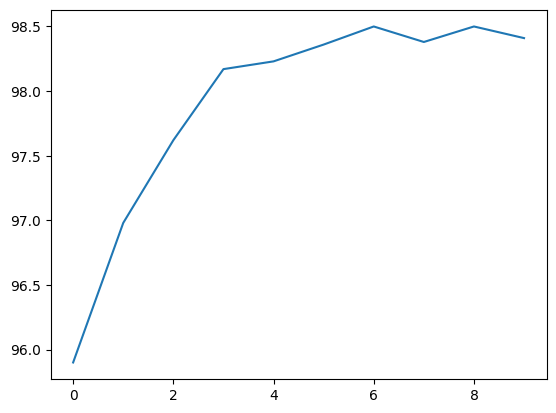

In [11]:
final_model = train_loop(num_epochs = 10)

#save the weights of the model for prediction
torch.save(final_model.state_dict(), "weights.pth")